Detected original bin width = 0.5 ms


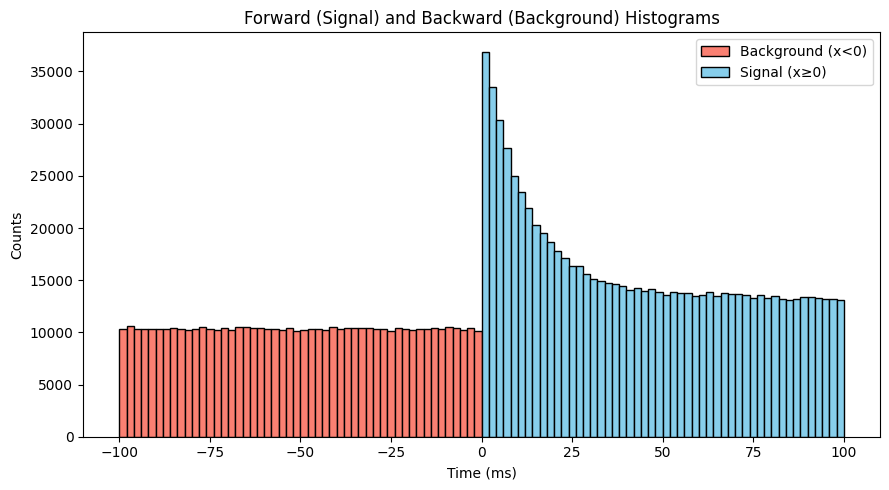

In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats import norm, uniform
import emcee
import corner
import math
import multiprocessing as mp

# --- Load ---
filename = "hist_33Na.csv"
df = pd.read_csv(filename)
if df.shape[1] > 2:
    df = df.iloc[:, :2]
df.columns = ["xVal", "yVal"]

x = df["xVal"].to_numpy(float)
y = df["yVal"].to_numpy(float)

# Sort by x
order = np.argsort(x)
x = x[order]
y = y[order]

# --- Infer original bin width ---
orig_bw = np.median(np.diff(x))
print(f"Detected original bin width = {orig_bw:.6g} ms")

# --- Ask for new bin width and range ---
new_bw = float(input(f"Enter NEW bin width (ms) [default {orig_bw}]: ") or orig_bw)
tstart = float(input(f"Enter START time (ms) [default {x.min()}]: ") or x.min())
tend   = float(input(f"Enter END time (ms) [default {x.max()}]: ") or x.max())

mask = (x >= tstart) & (x <= tend)
x_slice = x[mask]
y_slice = y[mask]

# --- Build bin edges for whole range ---
start_edge = x_slice[0] - 0.5 * orig_bw
end_edge   = x_slice[-1] + 0.5 * orig_bw
n_steps = int(np.ceil((end_edge - start_edge) / new_bw))
new_edges = start_edge + np.arange(n_steps + 1) * new_bw

# --- Rebin ---
y_rebinned, _ = np.histogram(x_slice, bins=new_edges, weights=y_slice)
new_centers = 0.5 * (new_edges[:-1] + new_edges[1:])

# --- Separate signal/background after rebin ---
sig_mask = new_centers >= 0
bg_mask  = new_centers < 0

# --- Plot as histograms ---
plt.figure(figsize=(9,5))
plt.bar(new_centers[bg_mask], y_rebinned[bg_mask], width=new_bw, 
        align='center', color='salmon', edgecolor='black', label='Background (x<0)')
plt.bar(new_centers[sig_mask], y_rebinned[sig_mask], width=new_bw, 
        align='center', color='skyblue', edgecolor='black', label='Signal (x≥0)')
plt.xlabel("Time (ms)")
plt.ylabel("Counts")
plt.title("Forward (Signal) and Backward (Background) Histograms")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:

def _parse_isotope(isot: str):
    s = isot.strip()
    m = re.match(r"^\s*([A-Za-z]+)\s*(\d+)\s*$", s) or re.match(r"^\s*(\d+)\s*([A-Za-z]+)\s*$", s)
    if not m:
        raise ValueError(f"Could not parse isotope: {isot}")
    if m.groups()[0].isalpha():
        return m.group(1).title(), int(m.group(2))
    else:
        return m.group(2).title(), int(m.group(1))

def _read_table(path, expected_cols, ncols):
    df = pd.read_csv(path, sep=r"[,\s]+", engine="python", comment="#", skip_blank_lines=True)
    # If no header or mismatched, re-read with no header and assign expected names
    if df.shape[1] < ncols or not set(c.lower() for c in df.columns).issuperset({c.lower() for c in expected_cols}):
        df = pd.read_csv(path, sep=r"[,\s]+", engine="python", comment="#", header=None)
        df = df.iloc[:, :ncols]
        df.columns = expected_cols
    else:
        # normalize and reorder
        lower = {c.lower(): c for c in df.columns}
        df = df[[lower[c.lower()] for c in expected_cols]]
    return df

def get_thalves(isot: str):
    elem, A = _parse_isotope(isot)

    # --- qbetas: get Z_parent and which channels are open ---
    q_cols = ["esymbol","Z","A","Qbeta","Qbeta_n","Qbeta_2n","Qbeta_3n"]
    qb = _read_table("qbetas", q_cols, 7)
    qb["esymbol"] = qb["esymbol"].astype(str).str.strip().str.title()

    row = qb[(qb["esymbol"] == elem) & (qb["A"] == A)]
    if row.empty:
        raise ValueError(f"No entry in 'qbetas' for {elem}{A}")
    Z_parent = int(row["Z"].iloc[0])

    # define these **before** any halflife lookup (prevents UnboundLocalError)
    daughterelemen = Z_parent + 1
    gdelemen       = Z_parent + 2

    Bn  = float(row["Qbeta_n"].iloc[0])  > 0
    B2n = float(row["Qbeta_2n"].iloc[0]) > 0
    B3n = float(row["Qbeta_3n"].iloc[0]) > 0

    # --- halflives: fetch T1/2 and error by (Z, A) ---
    h_cols = ["esymbol","Z","A","halflife","error"]
    hl = _read_table("halflives", h_cols, 5)

    def _fetch_T(Z, A_):
        m = (hl["Z"] == Z) & (hl["A"] == A_)
        if not m.any():  # allow missing
            return np.nan, np.nan
        r = hl[m].iloc[0]
        return float(r["halflife"]), float(r["error"])

    # daughter and granddaughter
    d_T,  d_Terr  = _fetch_T(daughterelemen, A)
    gd_T, gd_Terr = _fetch_T(gdelemen,      A)

    # neutron daughters if channels open
    nd_T = nd_Terr = np.nan
    n2d_T = n2d_Terr = np.nan
    n3d_T = n3d_Terr = np.nan
    if Bn:  nd_T,  nd_Terr  = _fetch_T(daughterelemen, A-1)
    if B2n: n2d_T, n2d_Terr = _fetch_T(daughterelemen, A-2)
    if B3n: n3d_T, n3d_Terr = _fetch_T(daughterelemen, A-3)

    # build array (same layout you expect)
    arr = [d_T, d_Terr]
    if Bn:  arr += [nd_T,  nd_Terr]
    if B2n: arr += [n2d_T, n2d_Terr]
    if B3n: arr += [n3d_T, n3d_Terr]
    arr += [gd_T]  # append GD T1/2 (no error, matching your original)
    return arr

def get_gdthalf(isot):
	ar = get_thalves(isot)
	return ar[-1]

############ get the number of n-daughters
def get_nds(anarray): ## an array should be the thalf_arr 
	print(len(anarray)/2)
	### number of neutron daughters 
	num_nds = int(len(anarray)/2 -1)
	#### return the array with correct number of parameters with appropriate pns
	return num_nds

In [39]:
############# generate prior
def gen_prior(anarray,bgarray):
	thalf_arr = anarray
	#priors = [uniform(0,1000),uniform(0,10000),norm(loc=np.mean(newbg),scale=np.std(newbg)),norm(loc=thalf_arr[0],scale=thalf_arr[1]),norm(loc=thalf_arr[2],scale=thalf_arr[3]),uniform(0,1)]
	priors = [uniform(0,500),uniform(0,100000),uniform(0,5000),norm(loc=thalf_arr[0],scale=thalf_arr[1]),norm(loc=thalf_arr[2],scale=thalf_arr[3]),uniform(0,1)]
	numtoadd = len(thalf_arr)/2 - 2
	numtoadd = int(numtoadd)
	for gg in np.arange(0,numtoadd):
		priors.append(norm(loc=thalf_arr[gg*2 +4],scale=thalf_arr[gg*2 + 5]))
		priors.append(uniform(0,1))
	#print(*priors)
	return priors

############# Bateman equations 

def gen_parent(x, *vals):
	a = vals[0] ### a is always the first param in vals 
	a=np.log(2)/a
	C1 = vals[1] ### C1 is always the second param in vals
	N = C1*np.exp(-a*x)
	return N

def gen_bg(x, *vals):
	bg = vals[2] ### bg is always third param in vals
	return bg

def gen_daughter(x, *vals):
	#print(*vals)
	a = vals[0]
	a = np.log(2)/a
	C1 = vals[1] 
	dl = vals[3] ### daughter t1/2 is always fourth in vals
	dl = np.log(2)/dl
	dC1 = dl*C1/(dl-a)
	dC2 = dl*C1/((a - dl))
	### get total non-Pn
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	#print('There are ', numpns, 'nd to add')
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	N = (1-Pn)*(dC1*np.exp(-a*x) + dC2*np.exp(-dl*x))
	return N	

def gen_ndaughter(x, *vals):
	a = vals[0]
	a = np.log(2)/a
	C1 = vals[1] 
	numpns = int(len(vals)-4)/2
	N = 0.
	for pp in np.arange(0,numpns):
		idx = int(4+2*pp)
		ndl = vals[idx]
		ndl = np.log(2)/ndl
		pn = vals[idx+1]
		ndC1 = ndl*C1/(ndl - a)
		ndC2 = ndl*C1/((a-ndl))
		thisN = (pn)*(ndC1*np.exp(-a*x) + ndC2*np.exp(-ndl*x))
		N += thisN	
	return N	

def gen_gdaughter(x, *vals):
	a = np.log(2)/vals[0]
	C1 = vals[1]
	dl = np.log(2)/vals[3]
	gdl = get_gdthalf(sys.argv[1])
	gdl = np.log(2)/gdl
	gdC1 = C1*dl*gdl/((dl-a)*(gdl-a))
	gdC2 = C1*dl*gdl/((a-dl)*(gdl-dl))
	gdC3 = C1*dl*gdl/((a-gdl)*(dl-gdl))
	N = gdC1*np.exp(-a*x) + gdC2*np.exp(-dl*x) + gdC3*np.exp(-gdl*x)
	return N
	
def chi2(bns,ex,calc):
	schi2 = []
	for idx,itm in enumerate(bns):
		#if(itm==0): c2 = 0
		#if(itm < tstart or itm > tend):
		#	c2=0
			#c2 = (itm-calc[idx])*(itm-calc[idx])
		c2 = (ex[idx]-calc[idx])*(ex[idx]-calc[idx])/ex[idx]
		schi2.append(c2)
	return sum(schi2)

def lnlikelihood(bns,ex,calc):
	lnl = []
	ttcts = []
	for idx,itm in enumerate(bns):
		#print(itm,tstart,tend)
		if(itm < tstart): ll=0
		elif(ex[idx] <0): ll=0
		else:
			ll = math.log(math.factorial(ex[idx])) + calc[idx] - ex[idx]*math.log(calc[idx])
			lnl.append(ll)
			#ttcts.append(ex[idx])
	#print('Total counts in decay curve is ')
	#print(sum(ttcts))
	return sum(lnl)

def sumln(vals): ##calculates how much posterior 'looks' like prior
	#a,C1,bg,dl,ndl,Pn=vals
	if(any([I < 0 for I in vals])): ##if any params < 0, toss
		return -np.inf
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	if(Pn>1.0): ##if sum pn > 1, toss
		return -np.inf
	return -lnlikelihood(newbins,newcts,bateman_easy(newbins,*vals))
	
def bateman_easy(x,*vals):
	N = gen_parent(x,*vals) + gen_daughter(x, *vals) + gen_ndaughter(x,*vals) + gen_bg(x,*vals) + gen_gdaughter(x,*vals)
	return N

def batemanmc(vals): 
	if(any([I < 0 for I in vals])):
		return -np.inf
	#if(any([I > 1000000 for I in vals])):
	#	return -np.inf
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	if(Pn>1):
		return -np.inf
	
	return -chi2(newbins,newcts,bateman_easy(newbins,*vals))/2

prior = [50,100,1,111,222,0.2,333,0.3,444,0.4] ##dummy prior

def lnprior(vals):
	lnpr = np.sum([pi.logpdf(g) for (pi,g) in zip(prior, vals)])
	return lnpr	

def fullprob(vals):
	prior = lnprior(vals)
	if(prior == -np.inf): return -np.inf
	else: return sumln(vals) + prior ## use this if low counts
	#else: return (batemanmc(vals) + prior) ## use this if have enough counts


In [41]:
import numpy as np
import emcee
import sys
ISOTOPE = "33Na"
sys.argv = [sys.argv[0], ISOTOPE]  # makes sys.argv[1] == "33Na"

# Ensure these exist from the rebin/plot cell:
assert "new_centers" in globals() and "y_rebinned" in globals() and "sig_mask" in globals() and "bg_mask" in globals()

# x/y for fit (signal region, x >= 0)
newbins = new_centers[sig_mask]              # x values (ms)
newcts  = y_rebinned[sig_mask].astype(float) # y values (counts)
newbg   = y_rebinned[bg_mask].astype(float)  # background counts (x < 0)

# --- half-lives from your helper functions (previous cell) ---
thalf_arr_full = get_thalves(ISOTOPE)   # [d_T, d_Terr, (nd_T, nd_Terr)..., gd_T]
thalf_arr = thalf_arr_full[:-1]         # drop GD value for prior list
num_nds = get_nds(thalf_arr)

print(f"There are {num_nds} neutron daughters")
print("thalf_arr:", thalf_arr)

# --- priors ---
prior = gen_prior(thalf_arr, newbg)   # NOTE: pass newbg, not bgarr
Npar = len(prior)
print("There are", Npar, "parameters")

# --- build init to match priors exactly ---
Nwalk = 30
Npar  = len(prior)

# basic scales
cts_scale = max(np.median(newcts), 1.0)
bg_scale  = max(np.median(newbg) if newbg.size else 0.1, 0.1)

# start with [parent_T, C1, bg, daughter_T]
init = [
    max(thalf_arr[0], 5.0),  # parent_T guess
    cts_scale,               # C1 amplitude
    bg_scale,                # bg per bin
    thalf_arr[0],            # daughter_T
]

# how many neutron daughters are in thalf_arr?
k_nd = get_nds(thalf_arr)  # k_nd = (len(thalf_arr) - 2) // 2

# add ALL neutron daughters as (nd_T, Pn) pairs
# thalf_arr layout (without GD): [d_T, d_Terr, nd1_T, nd1_Terr, nd2_T, nd2_Terr, ...]
for i in range(k_nd):
    idxT = 2 + 2*i
    init.append(thalf_arr[idxT])  # nd_i T1/2
    init.append(0.2)              # initial Pn_i guess

init = np.array(init, dtype=float)
assert init.size == Npar, f"Init size ({init.size}) != Npar ({Npar})"

# jitter walkers
rng = np.random.default_rng(42)
spread = 0.1 * np.maximum(np.abs(init), 1.0)
real_init = init + rng.normal(0, spread, size=(Nwalk, Npar))


# --- MCMC ---
Nsteps = 5000        # <- set steps explicitly (no sys.argv in notebook)
Nburn  = Nsteps // 4

sampler = emcee.EnsembleSampler(Nwalk, Npar, fullprob)
sampler.run_mcmc(real_init, Nsteps, progress=True)

# --- posterior summary ---
samps = sampler.get_chain(flat=True, discard=Nburn, thin=25)
p16, p50, p84 = np.percentile(samps, [16, 50, 84], axis=0)
bestvals = p50
uperr = p84 - p50
dnerr = p50 - p16

print(f"T1/2 = {bestvals[0]:.3g} (+{uperr[0]:.3g}/-{dnerr[0]:.3g})")

# compute sum of Pn across neutron daughters, append as last column for convenience
lenb = int((len(bestvals) - 4) / 2)  # number of (nd_T, Pn) pairs
Pn_sum = []
for row in samps:
    Pn = 0.0
    for pp in range(lenb):
        Pn += row[5 + 2*pp]
    Pn_sum.append(Pn)
newsamps = np.column_stack([samps, np.array(Pn_sum)])



4.0
There are 3 neutron daughters
thalf_arr: [90.2, 0.9, 80.4, 0.4, 270.0, 2.0, 314.0, 5.0]
There are 10 parameters
4.0


  1%|          | 27/5000 [00:01<05:08, 16.12it/s]


ValueError: Probability function returned NaN

0.0 100.0


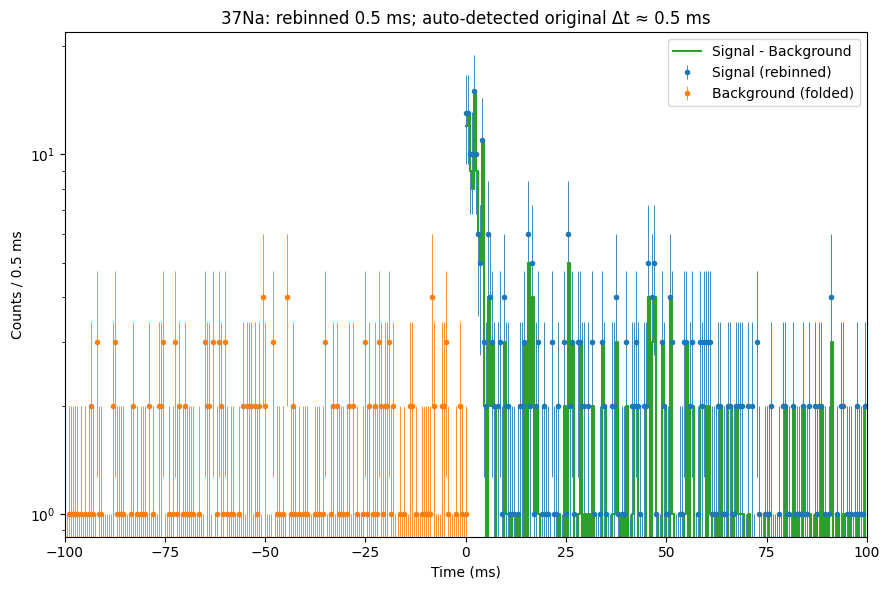

In [53]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats import norm, uniform
import emcee
import corner
import math
import multiprocessing as mp
import pandas as pd
#######
#Feb 16 2023 -> this is for emcee mcmc
#######
gdl=10000
### input 1 : isotope
### input 2 : ms per bin
### input 3 : start time (ms)
### input 4 : end time (ms)
### input 5 : MCMC times
sys.argv = ["notebook","37Na", "0.5", "0", "100", "5000"]
tstart = float(sys.argv[3])
tend = float(sys.argv[4])
print(tstart,tend)

#######
#######
# fFP1=open(sys.argv[1]+'.txt') ##filename is 'isotope',txt eg K51.txt 

# #### file stuff

# numbs = int(sys.argv[2]) #number of bins 
# arrcts = []
# bns, cts = [], []
# bns,cts,bbg = np.loadtxt(fFP1,usecols=(0,1,2),unpack=True)#,max_rows=int(tend))
# ## data file has 3 columns, binnum, forward corr counts, backward corr counts 
# ## it assumes that the binning factor in the input file is 1ms/bin
# bns = bns[int(tstart):int(tend)]
# #print(bns)
# cts = cts[int(tstart):int(tend)]
# bbg = bbg[int(tstart):int(tend)]

# ###rebin using new ms/bin from arg2
# for idx, itm in enumerate(bns):
# 	if(cts[idx]>0):
# 		for aa in np.arange(0,cts[idx]):
# 			arrcts.append(itm)

# bgarr = []
# for idx,itm in enumerate(bns):
# 	if(bbg[idx]>0):
# 		for aa in np.arange(0,bbg[idx]):
# 			bgarr.append(itm)

# binns = []
# for aa in np.arange(int(tstart),int(tend)):
# 	if(aa%numbs ==0): binns.append(aa+numbs)
# aarr = np.histogram(arrcts, binns)
# newcts=aarr[0]
# bbgarr = np.histogram(bgarr,binns)
# newbg = bbgarr[0]
# newbins = aarr[1]
# newbins = newbins[0:-1]
# nnewcts = newcts-newbg
# newbg = newbg[:-1]
# newbins = newbins[:-1]
# newcts = newcts[:-1]
isotope = sys.argv[1]
numbs = float(sys.argv[2]) #number ms/bins 
# ---------- read CSV ----------
csv_path = f"hist_{isotope}.csv"
df = pd.read_csv(csv_path)

# accept xval/XVal/xVal, yval/YVal/yVal
cols = {c.lower(): c for c in df.columns}
if "xval" not in cols or "yval" not in cols:
    raise ValueError("CSV must have columns named xval and yval (case-insensitive).")

x = df[cols["xval"]].to_numpy(dtype=float)
y = df[cols["yval"]].to_numpy(dtype=float)

# sanity: treat y as counts
y = np.asarray(np.round(y), dtype=int)
y[y < 0] = 0

# ---------- split signal/background by sign of bin center ----------
mask_pos = x >= 0
mask_neg = x < 0

# Auto-detect original bin width (use robust median of diffs on pos side)
if mask_pos.sum() >= 2:
    bw = np.median(np.diff(np.sort(x[mask_pos])))
else:
    # fall back to overall diffs if needed
    bw = np.median(np.diff(np.sort(x)))

# ---------- keep your original variable names ----------
# bns = bin centers for signal (>=0) within [tstart, tend)
in_win = (x >= tstart) & (x < tend)
mask_sig = mask_pos & in_win

bns = x[mask_sig]
cts = y[mask_sig]

# background: take negative times within mirrored window, fold to + side via abs()
mask_bg = mask_neg & (np.abs(x) >= tstart) & (np.abs(x) < tend)
bbg_centers = np.abs(x[mask_bg])   # fold
bbg_counts  = y[mask_bg]

# For parity with your old code where bbg aligned with bns, we won’t try to align per-bin here;
# we’ll just use bbg_* to build bgarr like you did.

# ---------- expand to event lists (vectorized) ----------
# (same idea as appending itm 'counts' times, but fast)
arrcts = np.repeat(bns, cts)
bgarr  = np.repeat(bbg_centers, bbg_counts)

# ---------- build rebin edges ----------
# Your original code created 'binns' as the RIGHT edges every 'numbs' ms.
# We'll create proper edges and also keep 'binns' name for compatibility.
edges = np.arange(tstart, tend + numbs, numbs, dtype=float)
binns = edges.copy()

# ---------- histogram/rebin ----------
aarr   = np.histogram(arrcts, edges)
newcts = aarr[0]

bbgarr = np.histogram(bgarr, edges)
newbg  = bbgarr[0]

newbins = edges[:-1]          # left edges as "bin centers" proxy (matches your usage)
nnewcts = newcts - newbg 

# 1) Signal (>=0), folded background (<=0), and total model slots
plt.figure(figsize=(9,6))

# signal on +t
plt.errorbar(
    newbins, newcts, yerr=np.sqrt(np.maximum(newcts, 1)),
    marker='o', linestyle='none', linewidth=0, elinewidth=0.6, ms=3, label='Signal (rebinned)'
)

# background on -t (folded)
plt.errorbar(
    -newbins, newbg, yerr=np.sqrt(np.maximum(newbg, 1)),
    marker='o', linestyle='none', linewidth=0, elinewidth=0.6, ms=3, label='Background (folded)'
)

# background-subtracted on +t
plt.step(newbins, np.maximum(nnewcts, 0), where='post', label='Signal - Background')

plt.semilogy()
plt.xlim(-tend, tend)
plt.xlabel('Time (ms)')
plt.ylabel(f'Counts / {numbs} ms')
plt.title(f'{isotope}: rebinned {numbs} ms; auto-detected original Δt ≈ {bw:.3g} ms')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [52]:
import math
import numpy as np
import re

def _parse_isotope(isot):
    s = isot.strip()
    m = re.match(r'^\s*(\d+)\s*([A-Za-z]+)\s*$', s)   # e.g., 33Na
    if not m:
        m = re.match(r'^\s*([A-Za-z]+)\s*(\d+)\s*$', s)  # e.g., Na33
    if not m:
        raise ValueError(f"Could not parse isotope '{isot}'. Expected like '33Na' or 'Na33'.")
    if m.group(1).isdigit():
        massA = int(m.group(1))
        elem = m.group(2)
    else:
        elem = m.group(1)
        massA = int(m.group(2))
    # Normalize element symbol capitalization (e.g., na -> Na)
    elem = elem.capitalize()
    return elem, massA

def _is_pos(x):
    # treat NaN or missing as not positive
    try:
        return (x is not None) and (not np.isnan(x)) and (float(x) > 0.0)
    except Exception:
        return False

def get_thalves(isot):
    elem, massA = _parse_isotope(isot)

    # --- read qbetas ---
    with open('qbetas', 'rb') as fpn:
        fpn_data = np.genfromtxt(
            fpn,
            dtype=[('esymbol','S5'),('Z','i4'),('A','i4'),
                   ('Qb','f8'),('Qbn','f8'),('Qb2n','f8'),('Qb3n','f8')],
            usecols=(0,1,2,3,4,5,6)
        )

    pn_enam     = [str(r['esymbol'], 'utf-8').strip().capitalize() for r in fpn_data]
    pn_elements = [int(r['Z']) for r in fpn_data]
    pn_massnum  = [int(r['A']) for r in fpn_data]
    pn_qb       = [float(r['Qb'])  for r in fpn_data]
    pn_qbn      = [float(r['Qbn']) for r in fpn_data]
    pn_qb2n     = [float(r['Qb2n']) for r in fpn_data]
    pn_qb3n     = [float(r['Qb3n']) for r in fpn_data]

    # --- read halflives ---
    with open('halflives', 'rb') as fhl:
        data = np.genfromtxt(
            fhl,
            dtype=[('esymbol','S5'),('Z','i4'),('A','i4'),('halflife','f8'),('error','f8')],
            usecols=(0,1,2,3,4)
        )

    enam    = [str(r['esymbol'], 'utf-8').strip().capitalize() for r in data]
    elements= [int(r['Z']) for r in data]
    massnum = [int(r['A']) for r in data]
    thalf   = [float(r['halflife']) for r in data]
    terr    = [float(r['error'])    for r in data]

    # Find Z for the input element; set daughter (Z+1) and granddaughter (Z+2)
    daughterelemen = None
    gdelemen = None
    for idx, sym in enumerate(enam):
        if sym == elem:
            daughterelemen = elements[idx] + 1
            gdelemen       = elements[idx] + 2
            break
    if daughterelemen is None or gdelemen is None:
        raise RuntimeError(f"Element '{elem}' not found in halflives table; check symbol casing and file content.")

    # Defaults
    dhalflife = dhalflife_err = 0.0
    gdhalflife = gdhalflife_err = 0.0

    # Direct daughter (same A, Z+1)
    for idx, Z in enumerate(elements):
        if Z == daughterelemen and massnum[idx] == massA:
            dhalflife     = thalf[idx]
            dhalflife_err = terr[idx]
            break

    # Granddaughter (same A, Z+2)
    for idx, Z in enumerate(elements):
        if Z == gdelemen and massnum[idx] == massA:
            gdhalflife     = thalf[idx]
            gdhalflife_err = terr[idx]
            break

    # Check Qβn channels (using qbetas)
    pn = p2n = p3n = -1
    for idx, sym in enumerate(pn_enam):
        if sym == elem and pn_massnum[idx] == massA:
            if _is_pos(pn_qbn[idx]):  pn  = 1
            if _is_pos(pn_qb2n[idx]): p2n = 1
            if _is_pos(pn_qb3n[idx]): p3n = 1
            break

    # Collect neutron-daughter half-lives if channels are open
    ndhalflife = ndhalflife_err = 0.0
    n2dhalflife = n2dhalflife_err = 0.0
    n3dhalflife = n3dhalflife_err = 0.0

    if pn > 0:
        # (Z+1, A-1)
        for idx, Z in enumerate(elements):
            if Z == daughterelemen and massnum[idx] == massA - 1:
                ndhalflife     = thalf[idx]
                ndhalflife_err = terr[idx]
                break

    if p2n > 0:
        # (Z+1, A-2)
        for idx, Z in enumerate(elements):
            if Z == daughterelemen and massnum[idx] == massA - 2:
                n2dhalflife     = thalf[idx]
                n2dhalflife_err = terr[idx]
                break

    if p3n > 0:
        # (Z+1, A-3)
        for idx, Z in enumerate(elements):
            if Z == daughterelemen and massnum[idx] == massA - 3:
                n3dhalflife     = thalf[idx]
                n3dhalflife_err = terr[idx]
                break

    # Build return array:
    # [D t1/2, D err, (nD t1/2, nD err)*, ..., GD t1/2]
    arr = [float(dhalflife), float(dhalflife_err)]
    if pn  > 0: arr += [float(ndhalflife),  float(ndhalflife_err)]
    if p2n > 0: arr += [float(n2dhalflife), float(n2dhalflife_err)]
    if p3n > 0: arr += [float(n3dhalflife), float(n3dhalflife_err)]
    arr += [float(gdhalflife)]  # keep your original convention (no GD err appended)

    return arr

def get_gdthalf(isot):
    ar = get_thalves(isot)
    return ar[-1]

def get_nds(thalf_arr):
    """
    thalf_arr is get_thalves() with the last GD value removed.
    It should then be: [D, D_err, (nD, nD_err)*]
    """
    L = len(thalf_arr)
    if L < 2 or (L % 2 != 0):
        # defensive: if malformed, say zero to avoid crashing
        return 0
    # pairs after the first (D,D_err) pair are the neutron daughters
    return (L // 2) - 1


############# generate prior
def gen_prior(anarray,bgarray):
	thalf_arr = anarray
	#priors = [uniform(0,1000),uniform(0,10000),norm(loc=np.mean(newbg),scale=np.std(newbg)),norm(loc=thalf_arr[0],scale=thalf_arr[1]),norm(loc=thalf_arr[2],scale=thalf_arr[3]),uniform(0,1)]
	priors = [uniform(0,500),uniform(0,100),uniform(0,5),norm(loc=thalf_arr[0],scale=thalf_arr[1]),norm(loc=thalf_arr[2],scale=thalf_arr[3]),uniform(0,1)]
	numtoadd = len(thalf_arr)/2 - 2
	numtoadd = int(numtoadd)
	for gg in np.arange(0,numtoadd):
		priors.append(norm(loc=thalf_arr[gg*2 +4],scale=thalf_arr[gg*2 + 5]))
		priors.append(uniform(0,1))
	#print(*priors)
	return priors

############# Bateman equations 

def gen_parent(x, *vals):
	a = vals[0] ### a is always the first param in vals 
	a=np.log(2)/a
	C1 = vals[1] ### C1 is always the second param in vals
	N = C1*np.exp(-a*x)
	return N

def gen_bg(x, *vals):
	bg = vals[2] ### bg is always third param in vals
	return bg

def gen_daughter(x, *vals):
	#print(*vals)
	a = vals[0]
	a = np.log(2)/a
	C1 = vals[1] 
	dl = vals[3] ### daughter t1/2 is always fourth in vals
	dl = np.log(2)/dl
	dC1 = dl*C1/(dl-a)
	dC2 = dl*C1/((a - dl))
	### get total non-Pn
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	#print('There are ', numpns, 'nd to add')
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	N = (1-Pn)*(dC1*np.exp(-a*x) + dC2*np.exp(-dl*x))
	return N	

def gen_ndaughter(x, *vals):
	a = vals[0]
	a = np.log(2)/a
	C1 = vals[1] 
	numpns = int(len(vals)-4)/2
	N = 0.
	for pp in np.arange(0,numpns):
		idx = int(4+2*pp)
		ndl = vals[idx]
		ndl = np.log(2)/ndl
		pn = vals[idx+1]
		ndC1 = ndl*C1/(ndl - a)
		ndC2 = ndl*C1/((a-ndl))
		thisN = (pn)*(ndC1*np.exp(-a*x) + ndC2*np.exp(-ndl*x))
		N += thisN	
	return N	

def gen_gdaughter(x, *vals):
	a = np.log(2)/vals[0]
	C1 = vals[1]
	dl = np.log(2)/vals[3]
	gdl = get_gdthalf(sys.argv[1])
	gdl = np.log(2)/gdl
	gdC1 = C1*dl*gdl/((dl-a)*(gdl-a))
	gdC2 = C1*dl*gdl/((a-dl)*(gdl-dl))
	gdC3 = C1*dl*gdl/((a-gdl)*(dl-gdl))
	N = gdC1*np.exp(-a*x) + gdC2*np.exp(-dl*x) + gdC3*np.exp(-gdl*x)
	return N
	
def chi2(bns,ex,calc):
	schi2 = []
	for idx,itm in enumerate(bns):
		#if(itm==0): c2 = 0
		#if(itm < tstart or itm > tend):
		#	c2=0
			#c2 = (itm-calc[idx])*(itm-calc[idx])
		c2 = (ex[idx]-calc[idx])*(ex[idx]-calc[idx])/ex[idx]
		schi2.append(c2)
	return sum(schi2)

def lnlikelihood(bns,ex,calc):
	lnl = []
	ttcts = []
	for idx,itm in enumerate(bns):
		#print(itm,tstart,tend)
		if(itm < tstart): ll=0
		elif(ex[idx] <0): ll=0
		else:
			ll = math.log(math.factorial(ex[idx])) + calc[idx] - ex[idx]*math.log(calc[idx])
			lnl.append(ll)
			#ttcts.append(ex[idx])
	#print('Total counts in decay curve is ')
	#print(sum(ttcts))
	return sum(lnl)

def sumln(vals): ##calculates how much posterior 'looks' like prior
	#a,C1,bg,dl,ndl,Pn=vals
	if(any([I < 0 for I in vals])): ##if any params < 0, toss
		return -np.inf
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	if(Pn>1.0): ##if sum pn > 1, toss
		return -np.inf
	return -lnlikelihood(newbins,newcts,bateman_easy(newbins,*vals))
	
def bateman_easy(x,*vals):
	N = gen_parent(x,*vals) + gen_daughter(x, *vals) + gen_ndaughter(x,*vals) + gen_bg(x,*vals) + gen_gdaughter(x,*vals)
	return N

def batemanmc(vals): 
	if(any([I < 0 for I in vals])):
		return -np.inf
	#if(any([I > 1000000 for I in vals])):
	#	return -np.inf
	numpns = (int(len(vals)-4)/2)
	Pn = 0.
	for pp in np.arange(0,numpns):
		idx = int(5 + 2*pp)
		#print(vals[idx])
		Pn+= vals[idx]
	if(Pn>1):
		return -np.inf
	
	return -chi2(newbins,newcts,bateman_easy(newbins,*vals))/2

prior = [50,100,1,111,222,0.2,333,0.3,444,0.4] ##dummy prior

def lnprior(vals):
	lnpr = np.sum([pi.logpdf(g) for (pi,g) in zip(prior, vals)])
	return lnpr	

def fullprob(vals):
	prior = lnprior(vals)
	if(prior == -np.inf): return -np.inf
	else: return sumln(vals) + prior ## use this if low counts
	#else: return (batemanmc(vals) + prior) ## use this if have enough counts

In [48]:
thalf_arr = get_thalves(sys.argv[1])
#gd_arr = thalf_arr[-2:-1]
thalf_arr = thalf_arr[:-1]
num_nds = get_nds(thalf_arr)
gdl = get_gdthalf(sys.argv[1])
print('There are ', num_nds, 'neutron daughters')
prior = gen_prior(thalf_arr,bgarr)
print(thalf_arr)

##### SET UP MCMC #####
Nwalk = 50
Npar = len(prior)
print('There are ',Npar,' parameters')
halves = []
for hh in np.arange(0,Npar):
	halves.append(0.5)
#print(newcts)
init_err = [50.,(0.5*(newcts[1])+1),((0.5*newbg[1])+0.1),thalf_arr[1]]
initial = [300.,(newcts[1]+1.),(newbg[1]+0.1),thalf_arr[0]]
numtoadd = len(thalf_arr)/2 - 2
numtoadd = int(numtoadd)
#print(numtoadd)
for gg in np.arange(0,numtoadd+1):
	idx = int(2*gg+3)
	init_err.append(thalf_arr[idx])
	init_err.append(0.2)
	initial.append(thalf_arr[idx-1])
	initial.append(0.4)
real_init = init_err*(np.random.random_sample((Nwalk,Npar))-halves) + initial
#print('init is ', real_init)
#print(np.mean(newbg), np.std(newbg))

####BEGIN MCMC#####
nsteps = int(sys.argv[5])
ndisc = int(nsteps/4)
#nsteps = 10000
with mp.Pool(8) as pool:
	sampler = emcee.EnsembleSampler(Nwalk,Npar,fullprob,pool=pool)
	sampler.run_mcmc(real_init,nsteps, progress=True)
#sampler = emcee.EnsembleSampler(Nwalk,Npar,fullprob)
#sampler.run_mcmc(real_init,nsteps, progress=True)
samps = sampler.get_chain(flat=True,discard=ndisc,thin=25) ##take 1/25 sample points
data_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samps, [16,50,84],axis=0))) #get sigma
aa = list(data_mcmc)
bestvals=[]
uperr = []
dnerr = []
for dd in np.arange(len(aa)):
	#print(aa[dd][0])
	bestvals.append(aa[dd][0])
	uperr.append(aa[dd][1])
	dnerr.append(aa[dd][2])
newsamps = []
print('T1/2 is ',bestvals[0], ' with up error ', uperr[0], ' and dn error ', dnerr[0])
lenb = (len(bestvals) - 4)/2
with open('fitparams.txt','a') as f:
	f.write(sys.argv[1])
	f.write('\t')
	for bb in bestvals:
		f.write(str(bb))
		f.write('\t')
	f.write('\n')
	#np.savetxt(f,bestvals)
with open('fituperr.txt','a') as f:
	f.write(sys.argv[1])
	f.write('\t')
	for bb in uperr:
		f.write(str(bb))
		f.write('\t')
	f.write('\n')
with open('fitdnerr.txt','a') as f:
	f.write(sys.argv[1])
	f.write('\t')
	for bb in dnerr:
		f.write(str(bb))
		f.write('\t')
	f.write('\n')
for idx, itm in enumerate(samps): ##sum Pn
	tlist=itm.tolist()
	Pn = 0.
	for pp in np.arange(0,lenb):
		Pn += tlist[int(5 + 2*pp)]	
	#print(tlist)
	tlist.append(Pn)
	newsamps.append(tlist)
newsamps = np.asarray(newsamps)

fnam2 = sys.argv[1] + '_output.dat'
np.savetxt(fnam2,samps)
##print(newsamps[0:5])
figg = plt.figure(figsize=(8,8))
fig = corner.corner(newsamps,show_titles=True,cmap='hot_r',fig=figg)
#plt.tight_layout()
#plt.savefig(sys.argv[1]+'-sq-'+sys.argv[2]+'bns-'+sys.argv[3]+'ms-ponly.pdf')
plt.show()
print(bestvals)

There are  2 neutron daughters
[90.2, 0.9, 80.4, 0.4, 270.0, 2.0]
There are  8  parameters


  0%|          | 0/5000 [00:00<?, ?it/s]/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 31/5000 [01:05<2:54:10,  2.10s/it]

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:




  params:
  params:
  params:
  params:  params:   params:    params:  params:   [2.86001652e+02 2.35782568e+04 9.51002583e+03 8.95890318e+01
 8.00999552e+01 3.66304587e-01 2.70061983e+02 4.31760708e-01] [2.26449452e+02 3.33905226e+03 9.30819812e+03 8.89001165e+01
 7.94500048e+01 5.02867735e-01 2.73375064e+02 1.78904783e-01][1.36959558e+02 7.84460527e+03 8.42656101e+03 8.95873010e+01
 7.97927023e+01 7.21272461e-01 2.75120109e+02 1.76892655e-01] 
[2.47657273e+02 1.10502445e+04 7.25625347e+03 9.06367814e+01
 7.96630980e+01 6.56454362e-01 2.662

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/emcee/ensemble.py", line 640, in __call__
    return se

KeyboardInterrupt: 

In [ ]:
fig2 = plt.figure(figsize=(8,6))
plt.errorbar(newbins,newcts,yerr=np.sqrt(newcts),marker='o',mfc='black',mec='black',linewidth=0,ecolor='black',elinewidth=0.5,ms=3,zorder=0)
plt.errorbar(-newbins,newbg,yerr=np.sqrt(newbg),marker='o',mfc='black',mec='black',linewidth=0,ecolor='black',elinewidth=0.5,ms=3,zorder=0)
plt.plot(newbins,bateman_easy(newbins,*bestvals),'r-',linewidth=2,label='Total')
plt.plot(newbins,gen_parent(newbins,*bestvals),'b-')
plt.plot(newbins,gen_daughter(newbins,*bestvals),'g-')
plt.plot(newbins,gen_ndaughter(newbins,*bestvals),color='purple')
plt.plot(newbins,gen_gdaughter(newbins,*bestvals),color='orange')
plt.plot([-tend,tend],[gen_bg(newbins,*bestvals),gen_bg(newbins,*bestvals)],'k--',linewidth=0.5,label='bg')
plt.plot([-tend,0],[gen_bg(newbins,*bestvals),gen_bg(newbins,*bestvals)],'r-',linewidth=2,label='bg')
plt.plot([-newbins[0],newbins[0]],[gen_bg(-newbins[0],*bestvals),bateman_easy(newbins[0],*bestvals)],'r--',linewidth=2,label='bg')
ttstr = sys.argv[1]+' '+'T1/2 is {:.2f}'.format(bestvals[0])+'ms with up error {:.2f}'.format(uperr[0])+'ms and dn error {:.2f}'.format(dnerr[0])+'ms'
plt.title(ttstr)
#plt.xlim(-tend/5,tend/2)
plt.xlim(-tend,tend)
plt.ylim(bestvals[2]/2.,np.max(newcts)*2)
plt.semilogy()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (ms)',fontsize=18)
plt.ylabel('Counts / [insert your bin size here] ms',fontsize=18)
#plt.savefig(sys.argv[1]+'-fit-'+sys.argv[2]+'msbns-'+sys.argv[3]+'to'+sys.argv[4]+'ms-only.pdf')
plt.show()
